----
# Analysis of the SA optimization
----

We optimized Tree-Tensor Networks (TNNs) using Simulated Annealing (SA).  
Here we visalize and analyze the results.

Date and content of runs:
- `2023-10-05`: small run to test the notebook. No MPI parallelization.
- `TEST`: small test with MPI parallelization (performed on 2023-11-27).
- `2023-11-27`: run for data collection. With MPI parallelization.

Sections:
- <a href=#load>Load the dataframe</a>
- <a href=#next>WIP</a>

----
<a id='top'></a>

In [9]:
# Set working directory to be the main directory of the repo.
import os
#try:
#    was_cwd_initialized
#except NameError:
#    os.chdir('ttn_learning/')
#    was_cwd_initialized = True
print('working directory:', os.getcwd())

import numpy as np              # Import NumPy library
import matplotlib.pyplot as plt # Import graphical library for plots
import pandas as pd
import sys
sys.path.insert(0, '../ttn_demo')
import ttn
# For certain runs, there is no way to know the slurm_jobid and slurm_procid if not manually.
from analysis_utils import get_id_of_files

# Name of files and directories
today = 'TEST'
today = '2023-11-27'
data_path = f'data/{today}_TTN_SA'

L = 24
site_dim = 2
bond_size = 3

working directory: /Users/mthib/Intel/pando-TN/ttn_learning


In [29]:
summary_fnames = [x for x in os.listdir(data_path) if f'L{L}_D{site_dim}_m{bond_size}_summary' in x]
hamval_fnames = [x for x in os.listdir(data_path) if f'L{L}_D{site_dim}_m{bond_size}_hamiltonian_val' in x]
summary_ids_split = [x.split('_')[2:5] for x in summary_fnames]
summary_ids = [f'_{x[0]}_{x[1]}_{x[2]}_' for x in summary_ids_split]
summary_val_pairs = []

# print(summary_ids)
for id in summary_ids:
    matching_summaries = [x for x in summary_fnames if id in x]
    matching_hamvals = [x for x in hamval_fnames if id in x]
    # print(matching_summaries, matching_hamvals)
    assert len(matching_summaries) <= 1 and len(matching_hamvals) <= 1
    if len(matching_summaries) == 0 or len(matching_hamvals) == 0:
        continue
    summary_val_pairs.append((matching_summaries[0], matching_hamvals[0]))
num_runs = len(summary_val_pairs)
print(f'{num_runs} runs available in this dataset')

55 runs available in this dataset


In [34]:

all_dfs = []

for summary_file_id, hamval_file_id in summary_val_pairs:

    with open(f'{data_path}/{summary_file_id}', 'rb') as f:
        df = pd.read_pickle(f)
    with open(f'{data_path}/{hamval_file_id}', 'rb') as f:
        hamvals = pd.read_pickle(f)

    all_dfs.append(df)
    # print(df)

    # get adjacency matrix
    # adj_matrix = df['state'][0].get_adjacency_matrix()

    # print(isinstance(df['state'][1], ttn.TTN))
    # print(isinstance(df['state'][2], ttn.TTN))
    # print(sum([isinstance(df['state'][j], ttn.TTN) for j in range(len(df['state']))]))

In [35]:
# set the matplotlib parameters
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}')

In [106]:
all_recorded_energies = []
all_ovps2 = []
acceptance_ratios = []

for df in all_dfs:
    non_recorded_states_idx = ~df['state'].notna()
    recorded_states_idx =  df['state'].notna()

    recorded_energies = df['energy'][recorded_states_idx]
    recorded_states = df['state'][recorded_states_idx]


    # compute the overlaps
    finalstateidx = recorded_energies.idxmin()
    min_energy = recorded_energies[finalstateidx]
    min_state = recorded_states[finalstateidx]

    # recorded_energies_

    num_accepted = len(df.index[df['state'].notna()])
    num_rejected = len(df.index[~df['state'].notna()])
    acceptance_ratios.append(num_accepted/(num_accepted+num_rejected))
    
    ovps_2 = [(min_state.H @ x)**2 for x in recorded_states]

    all_recorded_energies.append(recorded_energies)
    all_ovps2.append(ovps_2)
    # print(len(ovps_2), len(recorded_energies))


In [92]:
# interpolate the data for averaging
resample_pts = max(len(x) for x in all_ovps2)
interp_ovps2 = []
interp_energies = []
interp_energies_rel = []
interp_energies_offset = []
interp_energies_vs_final = []
interprange = np.linspace(0,1,resample_pts)
for ovp2, ee in zip(all_ovps2, all_recorded_energies):
    xdata = np.linspace(0,1,len(ovp2))
    interp_ovps2.append(np.interp(interprange, xdata, ovp2))
    interp_energies.append(np.interp(interprange, xdata, ee))
    interp_energies_rel.append(interp_energies[-1]/interp_energies[-1][-1])
    interp_energies_offset.append(interp_energies[-1] - interp_energies[-1][0])
    interp_energies_vs_final.append(interp_energies[-1] - interp_energies[-1][-1])

interp_ovps2 = np.array(interp_ovps2)
interp_energies = np.array(interp_energies)
interp_energies_rel = np.array(interp_energies_rel)
interp_energies_offset = np.array(interp_energies_offset)
interp_energies_vs_final = np.array(interp_energies_vs_final)


mean acceptance ratio: 11.02%


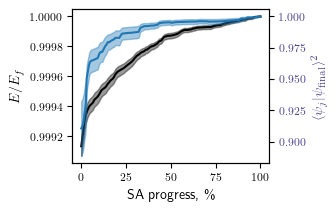

In [109]:
mean_energy = np.mean(interp_energies, axis=0)
mean_energy_rel = np.mean(interp_energies_rel, axis=0)
mean_energy_delta = np.mean(interp_energies_offset, axis=0)
mean_energy_vs_final = np.mean(interp_energies_vs_final, axis=0)
mean_ovp2 = np.mean(interp_ovps2, axis=0)

se_energy = np.std(interp_energies, axis=0) / np.sqrt(num_runs)
se_energy_rel = np.std(interp_energies_rel, axis=0) / np.sqrt(num_runs)
se_energy_delta = np.std(interp_energies_offset, axis=0) / np.sqrt(num_runs)
se_energy_vs_final = np.std(interp_energies_vs_final, axis=0) / np.sqrt(num_runs)
se_ovp2  = np.std(interp_ovps2, axis=0) / np.sqrt(num_runs)



ovp_color = 'darkslateblue'
energy_color = 'k'
xrange = interprange
fig, ax  = plt.subplots(1, 1, figsize=(3.25, 2.0), constrained_layout =True)
ax.plot(xrange * 100, mean_energy_rel, color='k')
ax.fill_between(xrange * 100, mean_energy_rel - se_energy_rel, mean_energy_rel + se_energy_rel, alpha=0.4, color=energy_color)
ax.set_xlabel('SA progress, \%')
ax.set_ylabel(r'$E / E_f$')
ax.tick_params(axis='y', labelcolor=energy_color)
ax.yaxis.label.set_color(energy_color)

ax_ovp = ax.twinx()
ax_ovp.plot(xrange * 100, mean_ovp2, color='C0')
ax_ovp.fill_between(xrange * 100, mean_ovp2 - se_ovp2, mean_ovp2 + se_ovp2, alpha=0.4, color='C0')
ax_ovp.set_ylabel(r'$\langle \psi_j|\psi_\textrm{final}\rangle^2$')
ax_ovp.tick_params(axis='y', labelcolor=ovp_color)
ax_ovp.yaxis.label.set_color(ovp_color)
plt.savefig('/Users/mthib/Intel/pando-TN/report/figures/TTN_SA_runs_avg.pdf')

print(f'mean acceptance ratio: {np.mean(acceptance_ratios) * 100:.2f}%')


Num accepted SA moves: 121/1001 = 12.09 %


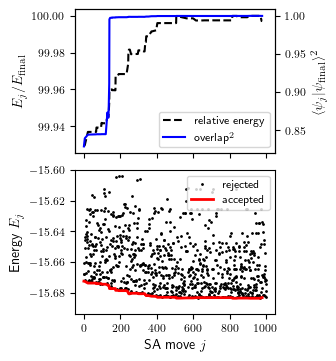

In [5]:
# To focus on the accepted moves, set the variable below:
only_accepted = True




fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.25, 3.5), constrained_layout =True, sharex=True)
# plt.subplots_adjust(hspace=0.3)
# plt.suptitle(f'{today}:  L={L} , D={site_dim} , m={bond_size} , r={run}',  y=1.06)


# Plot the data with 'o' marker for states where 'state' is None
ax2.plot(df.index[~df['state'].notna()], df['energy'][~df['state'].notna()],
        marker='o', linestyle='', color='k', ms=1,label='rejected')
# Plot the data with 'x' marker for accepted states
ax2.plot(df.index[df['state'].notna()], df['energy'][df['state'].notna()],
        marker='', linestyle='-', linewidth=2, color='red', label='accepted')

ax_ovp = ax1.twinx()

ax1.plot(df.index[df['state'].notna()], df['energy'][df['state'].notna()]/min_energy * 100,
        marker='', linestyle='--', color='k', label='relative energy')
ax_ovp.plot(df.index[df['state'].notna()], ovps_2,
        marker='', linestyle='-', color='b', label=r'overlap$^2$')


ax1.set_ylabel(r'$E_j/E_\textrm{final}$')
ax_ovp.set_ylabel(r'$\langle \psi_j|\psi_\textrm{final}\rangle^2$')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax_ovp.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

# ax2.set_xlabel('SA move $j$'); 
# ax2.set_ylabel('Energy $E_j$'); 
ax2.legend()

# ax2.set_ylim((min_energy - 0.01,-15.6, ))

# Count how many SA moves were accepted/rejected.
num_accepted = len(df.index[df['state'].notna()])
num_rejected = len(df.index[~df['state'].notna()])
print(f'\nNum accepted SA moves: {num_accepted}/{num_accepted+num_rejected} = {num_accepted/(num_accepted+num_rejected)*100:5.2f} %')
# plt.show()

plt.savefig('/Users/mthib/Intel/pando-TN/report/figures/single_TTN_SA_run.pdf')

Generate the Hamiltonian values / TTN state adjacency matrices for learning

In [6]:
L = 24


----
## END
----